In [1]:
#We have loaded the packages and functions which we will need later.
import pandas as pd
import etl, graph_manipulation as gm, data_viz as dv
from tqdm import tqdm
import networkx as nx
from sklearn.metrics import accuracy_score, confusion_matrix


Bad key "text.kerning_factor" on line 4 in
D:\Python\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#We have loaded the data, with the function which also cleans it, and selects relevant profiles only.
nodes, edges = etl.load_and_select_profiles_and_edges()

loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590


In [3]:
#we've created a graph as well from the data.
G=  gm.create_graph_from_nodes_and_edges(nodes, edges)
nodes

,user_id,public,gender,region,AGE,TRAIN_TEST
0,1,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN
4,4,1,0.0,"banskobystricky kraj, brezno",26.0,TRAIN
5,17,1,0.0,"zilinsky kraj, martin",27.0,TRAIN
6,5,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN
7,18,1,1.0,"zilinsky kraj, kysucke nove mesto",18.0,TRAIN
...,...,...,...,...,...,...
1632778,1632779,1,NaN,"trenciansky kraj, myjava",NaN,TEST
1632781,1632782,1,NaN,"bratislavsky kraj, bratislava - nove mesto",NaN,TEST
1632782,1632783,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN
1632784,1632785,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN


In [4]:
#We've splitted the database to a train and test database.
is_train =  nodes['TRAIN_TEST']=='TRAIN'
nodes_train = nodes[is_train]
is_test =  nodes['TRAIN_TEST']=='TEST'
nodes_test = nodes[is_test]

In [5]:
#we created graphs from the test and train data base.
G_test = gm.create_graph_from_nodes_and_edges(nodes_test, edges)
G_train = gm.create_graph_from_nodes_and_edges(nodes_train, edges)

In [6]:
#Now we should count the number of friends by gender for each node, but it would be a really computing-intensive task, 
#to go through all the 394590 rows in the nodes_train dataset.
#That is why we connected the counting-process directly with the prediction.
#We counted through iteration the neighbors of each node grouped by gender. If a node had more female neighbors than male, 
#we predicted it's gender female, otherwise male. 

In [7]:
pred_gend = []
for userid in tqdm(nodes_test.user_id):
    neighbors_it = set(G_train.neighbors(userid))
    genders = nodes_train[nodes_train.user_id.isin(neighbors_it)].dropna() \
        .groupby('gender').count()
    try:
        males = genders.loc[1, 'user_id']
    except:
        males = 0
    try:
        females = genders.loc[0, 'user_id']
    except:
        females = 0

    if males >= females:
        pred_gend.append(1)
    else:
        pred_gend.append(0)
    

prediction = pd.DataFrame(dict(user_id = nodes_test.user_id, gender = pred_gend))

100%|██████████| 40000/40000 [11:14<00:00, 59.30it/s]


In [8]:
#We created a function to measure the accuracy with an accuracy score and 
#a confusion matrix of any prediction which we can use any time, to see the results at one time.
def accuracy_check(test, pred):
    accuracyscore = accuracy_score(test, pred)
    confusionmatrix = confusion_matrix(test, pred)
    print(f"The confusion matrix is:\n{confusionmatrix}\n\nThe accuracy score is: {accuracyscore}")

In [9]:
#This code below doesn't work, while in the given data the test nodes had no gender values,
#that is why they are not comparable with the results of the prediction:(

In [10]:
y_test = nodes_test.gender.dropna()
y_prediction = prediction.gender
accuracy_check(y_test, y_prediction)

ValueError: Found input variables with inconsistent numbers of samples: [0, 40000]

In [11]:
#2.exercise
#Plotting

In [12]:
#Packages for plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

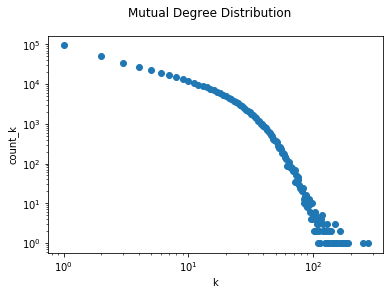

In [13]:
dv.plot_degree_distribution(G)

This log-log plot has been created to show the mutual degree distribution of the graph, itself.
According to our studies, this degree distribution is not scale-free, because after a while it breaks down.
A log-log plot has two dimensions, and both of the axes show the logarithmic value of the two variables.

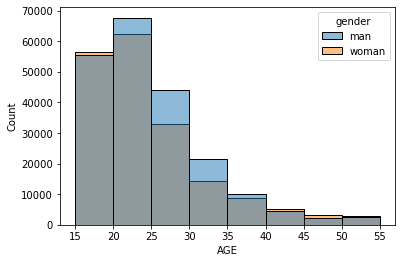

In [14]:
# descriptive analytics of the nodes
# age distribution by gender
dv.plot_age_distribution_by_gender(nodes)

This frequency histogram shows us the age distribution of the graph.
According to the histogram, a huge number of young people (aged between 20 and 25) are in the dataset. The main reason is that this dataset is from an online platform, which is nowadays used mainly by the younger generation.
After the age of 25, the histogram shows us a huge decline. A people are getting older, the less the chances are that they use online networks to keep contact with each other.
The distribution by sex indicates that there are more male users in the network than female ones. However, after the age of 40 there are more and more female users.
The maximum age of the dataset is 55. This is just only a tiny proportion of this huge dataset.

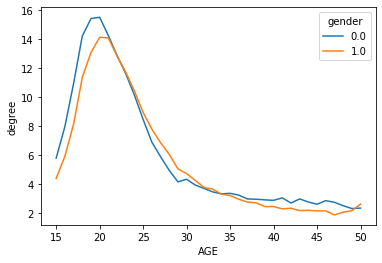

In [15]:
dv.plot_node_degree_by_gender(nodes, G)

This line chart above shows interesting pieces of information about the degree of both female and male users.
The chart uses the number of the genders, such as 0 is for women and 1 for men.
The line chart achieve its peak values at the age of nearly 18-20 among women and about 20-22 among male users.
After these peaks, a huge shrinkage brings into being. After the age of 35, the are still more women than man in the graph.
The small number of low values is due to the fact that there are fewer people, who are still part of the online world. 

In [16]:
#We need the same for neighbor connectivity, triadic closure (local clustering coefficient)
#we need to add these attributes to the nodes dataframe so we can plot them

In [17]:
#adding two more attributes to the nodes dataframe
nodes = nodes.assign(connectivity = nodes.user_id.map(nx.average_neighbor_degree(G)))
nodes = nodes.assign(tri_closure = nodes.user_id.map(nx.clustering(G)))
nodes

,user_id,public,gender,region,AGE,TRAIN_TEST,connectivity,tri_closure
0,1,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN,13.500000,0.000000
4,4,1,0.0,"banskobystricky kraj, brezno",26.0,TRAIN,6.000000,0.000000
5,17,1,0.0,"zilinsky kraj, martin",27.0,TRAIN,11.000000,0.166667
6,5,1,1.0,"zilinsky kraj, zilina",26.0,TRAIN,12.285714,0.190476
7,18,1,1.0,"zilinsky kraj, kysucke nove mesto",18.0,TRAIN,24.230769,0.192308
...,...,...,...,...,...,...,...,...
1632778,1632779,1,NaN,"trenciansky kraj, myjava",NaN,TEST,1.000000,0.000000
1632781,1632782,1,NaN,"bratislavsky kraj, bratislava - nove mesto",NaN,TEST,2.000000,0.000000
1632782,1632783,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN,1.000000,0.000000
1632784,1632785,1,1.0,"trenciansky kraj, povazska bystrica",37.0,TRAIN,1.000000,0.000000


In [18]:
#We have added to the function of plotting these attributes as a new parameter

In [19]:
def plot_node_stats_by_gender(nodes, G, stats):
    """Plot the average of node degree across age and gender"""
    # TODO: this could be generalized for different node level statistics as well!
    

    
    nodes_w_degree = nodes.set_index("user_id").merge(
        pd.Series(dict(G.degree)).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
    )
    nodes_w_degree = nodes_w_degree.rename({0: "degree"}, axis=1)
    plot_df = (
        nodes_w_degree.groupby(["AGE", "gender"]).agg({"degree": "mean"}).reset_index()
    )
    
    
    if stats == "degree":
        sns.lineplot(data=plot_df, x="AGE", y="degree", hue="gender")
    elif stats == "connectivity":
        sns.lineplot(data=nodes, x="AGE", y="connectivity", hue="gender")
    else:
        sns.lineplot(data=nodes, x="AGE", y="tri_closure", hue="gender")

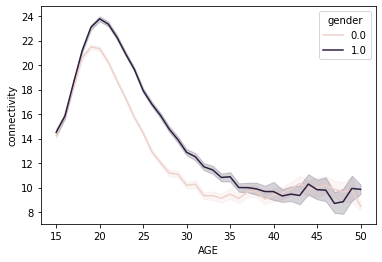

In [20]:
plot_node_stats_by_gender(nodes, G, 'connectivity')

For the connectivity chart a peak around between 20 and 25 can also been seen, likewise the graph before. After this age, a decline is also visible, meaning people tend to speak less as they age. However, a second bump is also noticable between 43-46.
According to the chart male users have higher connectivity, than women.

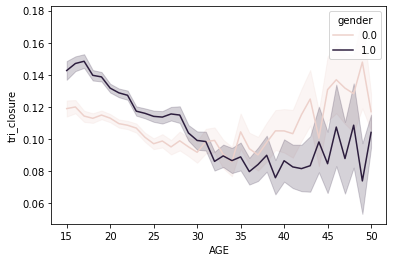

In [21]:
plot_node_stats_by_gender(nodes, G, 'tri_closure')

This chart provides us information about the triadic closure, the local clustering coefficient. The clustering coefficient both for female and male users declines until the age of 40. After this decline, huge clustering coefficients can be seen for both sexes. Young people using social media platforms usually extend their acquaintanceship. Elder people have less but stable connection. As a result of this fact, higher clustering coefficients can be obtained at this age by the data.

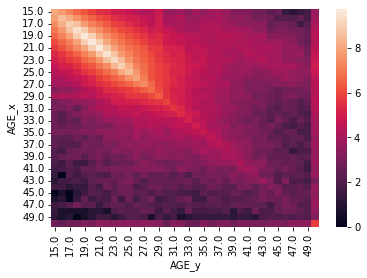

In [22]:
edges_w_features = gm.add_node_features_to_edges(nodes, edges)
dv.plot_age_relations_heatmap(edges_w_features)
# THE END

In [23]:
#We have modified the underlying function to separate genders and to try out without logging, and normalizing as well

In [24]:
def plot_age_relations_heatmap_methods(edges_w_features, method):
    """Plot a heatmap that represents the distribution of edges"""
    # TODO: check what happpens without logging
    # TODO: instead of logging check what happens if you normalize with the row sum
    #  make sure you figure out an interpretation of that as well!
    # TODO: separate these charts by gender as well
    # TODO: column names could be nicer
    plot_df = edges_w_features.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    plot_df_w_w = plot_df.loc[(0, 0)].reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    plot_df_heatmap_normed = np.linalg.norm(plot_df_heatmap + 1, ord='fro')
    
    if method == "log":
        sns.heatmap(plot_df_heatmap_logged)
    elif method == "norm":
        sns.heatmap(plot_df_heatmap_normed)
    else:
        sns.heatmap(plot_df_heatmap)

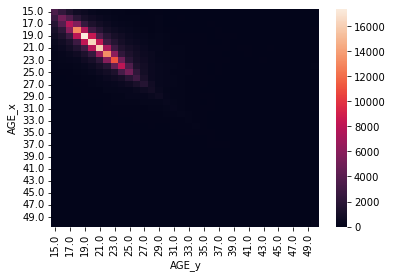

In [25]:
#We can show the logged, the normed, and the basic (no-logging) heatmap. Unfortunately the normed plot is not working.
#Basic version:
plot_age_relations_heatmap_methods(edges_w_features, "basic")

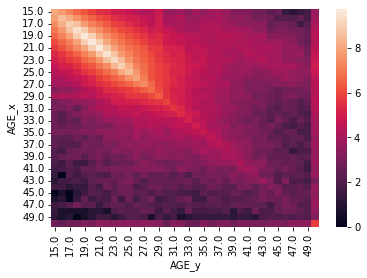

In [26]:
#Logged version:
plot_age_relations_heatmap_methods(edges_w_features, "log")

This logged version of the heat map provides a lot of valuable information about people's life.
The x axis shows the age of men, and the y axis shows the age of women. This data corresponds to gender and age homophily.
At the age of 25, the most striking feature is that contact with younger people is more common than with older people. Here, in our opinion, people are in the phase of getting to know each other. In this section of life, men are older than women. Then, after the period, this trend becomes less and less apparent. Presumably, after the dating period, people will be immersed in everyday life. Friendship among men and women after a while ceases to exist.
At the age of 49, as it can be seen from the heat map, we get an exceptionally high value.

In [33]:
#MM version
def plot_age_relations_heatmap_methods_MM(edges_w_features, method):
    """Plot a heatmap that represents the distribution of edges"""
    # TODO: check what happpens without logging
    # TODO: instead of logging check what happens if you normalize with the row sum
    #  make sure you figure out an interpretation of that as well!
    # TODO: separate these charts by gender as well
    # TODO: column names could be nicer
    plot_df = edges_w_features.groupby(["gender_y", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    plot_df_w_w = plot_df.loc[(0, 0)].reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    plot_df_heatmap_normed = np.linalg.norm(plot_df_heatmap + 1, ord='fro')
    
    if method == "log":
        sns.heatmap(plot_df_heatmap_logged)
    elif method == "norm":
        sns.heatmap(plot_df_heatmap_normed)
    else:
        sns.heatmap(plot_df_heatmap)

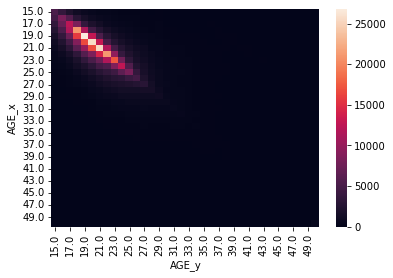

In [34]:
plot_age_relations_heatmap_methods_MM(edges_w_features, "basic")

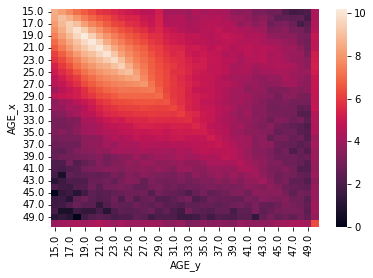

In [37]:
#Log version
plot_age_relations_heatmap_methods_MM(edges_w_features, "log")

On this logged version of the heat map both the axes belong to male users. In this section we wanted to get an answer how men keep contact with each other, which age groups "belong together".
A diagonal can be seen in the middle of the heat map. It means, people in the same age group communicate with each other the most. Looking at the area next to the diagonal, it is clear that the young age (up to 30 years) group communicates nearly in the same way with friends who are a few years older. This means, that men favour more bigger social connections. Also in the previous graph, at the age of 49, we get an exceptionally high value.

In [35]:
#FF version
def plot_age_relations_heatmap_methods_FF(edges_w_features, method):
    """Plot a heatmap that represents the distribution of edges"""
    # TODO: check what happpens without logging
    # TODO: instead of logging check what happens if you normalize with the row sum
    #  make sure you figure out an interpretation of that as well!
    # TODO: separate these charts by gender as well
    # TODO: column names could be nicer
    plot_df = edges_w_features.groupby(["gender_x", "gender_x", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    plot_df_w_w = plot_df.loc[(0, 0)].reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    plot_df_heatmap_normed = np.linalg.norm(plot_df_heatmap + 1, ord='fro')
    
    if method == "log":
        sns.heatmap(plot_df_heatmap_logged)
    elif method == "norm":
        sns.heatmap(plot_df_heatmap_normed)
    else:
        sns.heatmap(plot_df_heatmap)

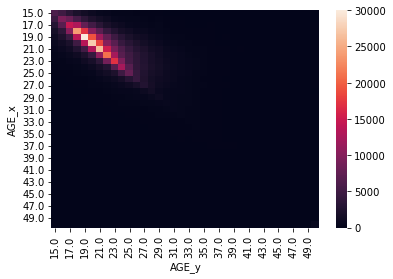

In [36]:
plot_age_relations_heatmap_methods_FF(edges_w_features, "basic")

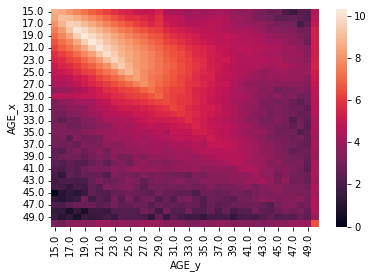

In [38]:
#Log version
plot_age_relations_heatmap_methods_XX(edges_w_features, "log")

On this logged version of the heat map both the axes belong to female users. 
In general, most friendships are made at a younger age, which is true for both genders. People in the same age group communicate with each other the most. Looking at the area next to the diagonal, it is clear that the young age (up to 30 years) group communicates nearly in the same way with friends who are a few years older.